In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
#let us start by importing the relevant libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
# to suppress scientifiv notations
pd.set_option('display.float_format', lambda x: '%.2f' % x)

**Define the problem and perform an Exploratory Data Analysis**

In [5]:
data = pd.read_excel('Credit Card Customer Data.xlsx')

View the first and last 5 rows of the dataset

In [6]:
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [7]:
data.shape

(660, 7)

The data set has 660 rows and 7 columns

Check the data types of the columns for the dataset

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


There are no null values in the data. All columns are numerical.

Summary of the dataset.¶

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.00,330.50,190.67,1.00,165.75,330.50,495.25,660.00
Customer Key,660.00,55141.44,25627.77,11265.00,33825.25,53874.50,77202.50,99843.00
Avg_Credit_Limit,660.00,34574.24,37625.49,3000.00,10000.00,18000.00,48000.00,200000.00
Total_Credit_Cards,660.00,4.71,2.17,1.00,3.00,5.00,6.00,10.00
Total_visits_bank,660.00,2.40,1.63,0.00,1.00,2.00,4.00,5.00
Total_visits_online,660.00,2.61,2.94,0.00,1.00,2.00,4.00,15.00
Total_calls_made,660.00,3.58,2.87,0.00,1.00,3.00,5.00,10.00


* Sl_No : This key looks a duplicate record but it is okay as this kind of key is generated when a databse added a serial number like SQL. Hence, it is under my observation it is not the same as Customer_Key.

* Customer_Key has a mean value of 55141

* The mean credit cards is 4.7 with a minimum value of 1 and maximum value of 10.
* Total Visits_bank shows a maximum visit of 5
* Tocal visits online shows a maximum visit of 15 which shows more customers are visting online not in Bank.
* Total calls made is maximum of 10 and minum of 0 customers makes call.

In [10]:
data.drop(['Sl_No'], axis=1, inplace=True)


check if there is any missing value

In [11]:
data.isna().sum()

Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

Check duplicate records in the Customer_Key column

In [12]:
# finding duplicatred rows
duplicate_rows = data[data.duplicated()]
duplicate_rows

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made


In [13]:
# even if the duplicated() funcation does not show any duplicates below query finds duplicates 

gb_cccd = data.groupby('Customer Key').count()
print('There are',gb_cccd.loc[gb_cccd.Total_calls_made >=2].shape[1], 'duplicate entries for Customer Key')

for k in list(gb_cccd.loc[gb_cccd.Total_calls_made >=2].index):
    display(data.loc[data['Customer Key'] == k])

There are 5 duplicate entries for Customer Key


,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,37252,6000,4,0,2,8
432,37252,59000,6,2,1,2


,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
4,47437,100000,6,0,12,3
332,47437,17000,7,3,1,0


,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
411,50706,44000,4,5,0,2
541,50706,60000,7,5,2,2


,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
391,96929,13000,4,5,0,0
398,96929,67000,6,2,2,2


,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
104,97935,17000,2,1,2,10
632,97935,187000,7,1,7,0



Customer_key shows five duplicates of key 3752,4737,5076,96929,97935

However, from the total of 660 rows, there are less than 1% of the data that is duplicated, then i will leave it as is.



'Customer Key' is irrelevant for this analysis due to the duplicate.

In [14]:
data.drop(['Customer Key'], axis=1, inplace=True)

Calculate outliers using IQR

In [15]:
# function to calculate the IQR and upper and lower bound range

def calculateIQR(col) :
  Q1 = np.percentile(col, 25, interpolation='midpoint')
  Q3 = np.percentile(col, 75, interpolation='midpoint')
  IQR = Q3-Q1
  lower_bound = Q1 -(1.5 * IQR)
  upper_bound = Q3 + (1.5 * IQR)
  return lower_bound, upper_bound

In [16]:
for col in data.columns :
  if data[col].dtypes in ('int64', "float64") :
    lower_range, upper_range = calculateIQR(data[col])
    print("---------------- " + col +  "--------------------------------------------")
    print("upper-range outliers - ", data[data[col] > upper_range].shape[0])
    print("% upper-range outliers - ", (data[data[col] > upper_range].shape[0] / data.shape[0])* 100)
    print("lower-range outliers - ", data[data[col] < lower_range].shape[0])
    print("% lower-range outliers - ", (data[data[col] < lower_range].shape[0] / data.shape[0]) * 100)
    

---------------- Avg_Credit_Limit--------------------------------------------
upper-range outliers -  39
% upper-range outliers -  5.909090909090909
lower-range outliers -  0
% lower-range outliers -  0.0
---------------- Total_Credit_Cards--------------------------------------------
upper-range outliers -  0
% upper-range outliers -  0.0
lower-range outliers -  0
% lower-range outliers -  0.0
---------------- Total_visits_bank--------------------------------------------
upper-range outliers -  0
% upper-range outliers -  0.0
lower-range outliers -  0
% lower-range outliers -  0.0
---------------- Total_visits_online--------------------------------------------
upper-range outliers -  37
% upper-range outliers -  5.606060606060606
lower-range outliers -  0
% lower-range outliers -  0.0
---------------- Total_calls_made--------------------------------------------
upper-range outliers -  0
% upper-range outliers -  0.0
lower-range outliers -  0
% lower-range outliers -  0.0


Outliers detection shows a total of online visitors of 5.6 % and average credit limit of 5.9%.

Illustrate the insights based on EDA

**Univariate Analysis**

In [17]:
# Function to display the displot for the columns.

def univariatePlots(data) :
  for col in data.columns :
    if (data[col].dtypes in ("int64", "float64")) :
      print("Distplot for numeric column : " , col);
      sns.displot(data[col], kde=True);
    plt.show()

Distplot for numeric column :  Avg_Credit_Limit


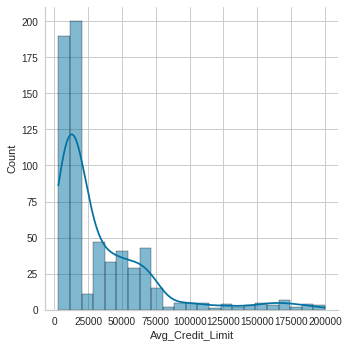

Distplot for numeric column :  Total_Credit_Cards


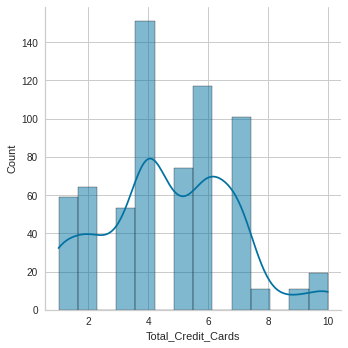

Distplot for numeric column :  Total_visits_bank


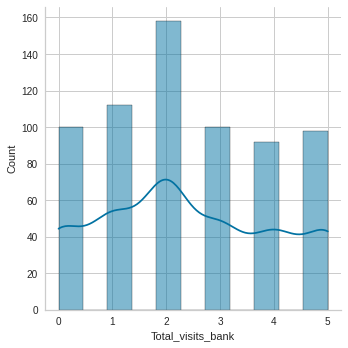

Distplot for numeric column :  Total_visits_online


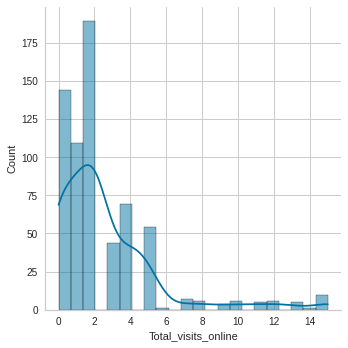

Distplot for numeric column :  Total_calls_made


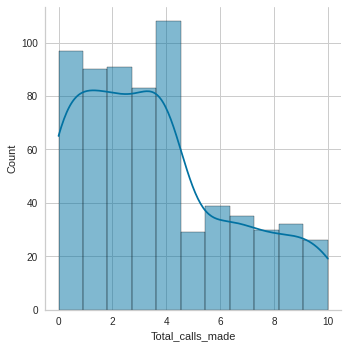

In [18]:
univariatePlots(data)

Observations : 
- Total_credit_cards shows signs dual distribution , having two set of peaks. 
- Total_visits_bank is uniformly distributed.
- Total_visits_online is left skewed

Bivariate analysis

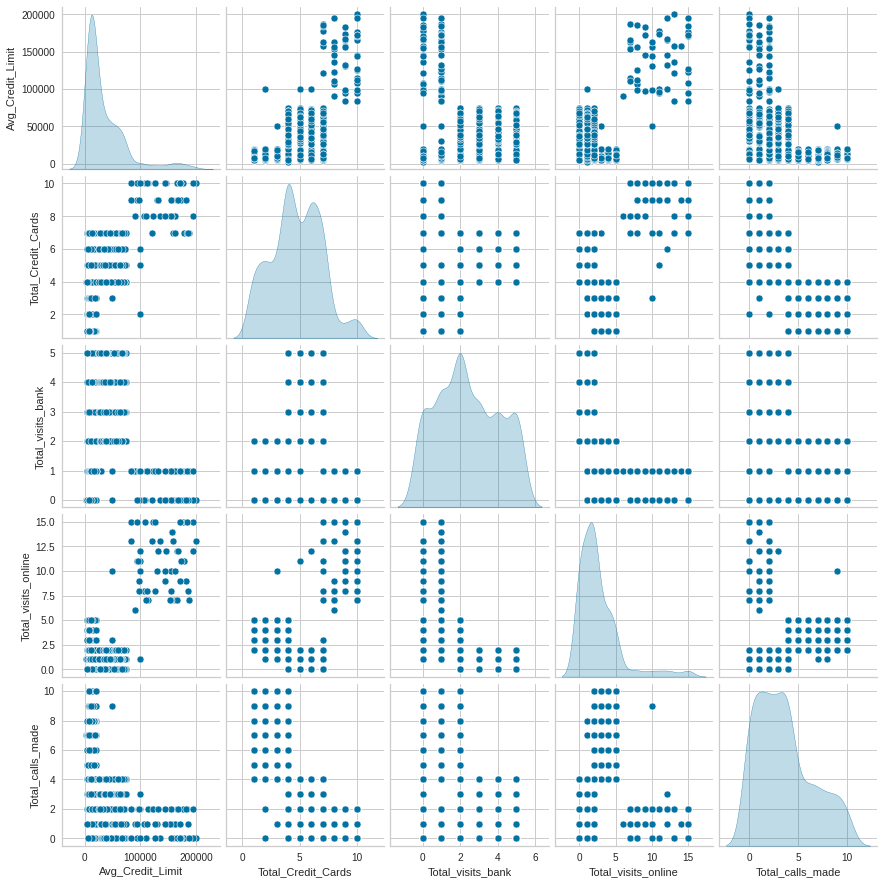

In [19]:
#  pairplot for the dataset , with  as kde

sns.pairplot(data, diag_kind='kde')

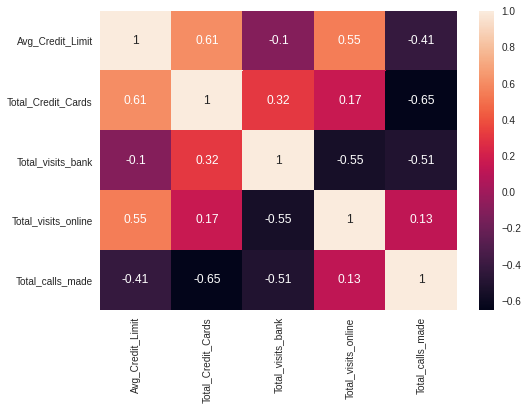

In [20]:
 # heatmap

corr = data.corr()
sns.heatmap(corr, annot=True)

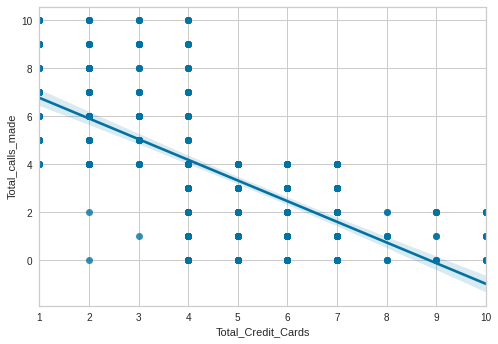

In [21]:
sns.regplot(data['Total_Credit_Cards'], data['Total_calls_made'])

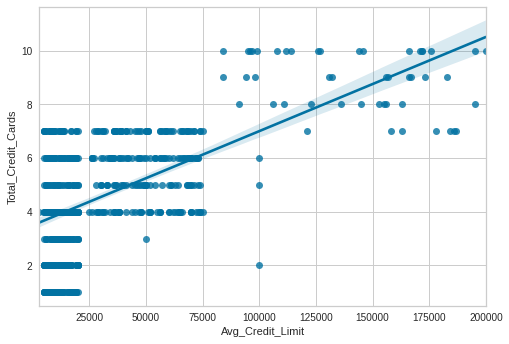

In [22]:
sns.regplot(data['Avg_Credit_Limit'], data['Total_Credit_Cards'])

Insights : 
 - Total_Credit_Cards and Total_calls_made have negative correlation
 - Avg_Credit_Limit and Total_Credit_Cards have positive correlation

In [23]:
# the avg_credit_limit has no value for clustering.

data.drop(['Avg_Credit_Limit'], axis=1, inplace=True)

K-means clustering

In [86]:
# Importing the standard scaller 
from sklearn.preprocessing import StandardScaler

std_scaller = StandardScaler()
scaller = std_scaller.fit(data)

In [87]:
scaller.mean_

array([4.70606061, 2.4030303 , 2.60606061, 3.58333333])

In [88]:
scalled = scaller.transform(data)
data_s = pd.DataFrame(scalled, columns=data.columns)
data_s.head()

,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,-1.25,-0.86,-0.55,-1.25
1,-0.79,-1.47,2.52,1.89
2,1.06,-0.86,0.13,0.15
3,0.14,-0.86,-0.55,0.15
4,0.60,-1.47,3.20,-0.20


In [89]:
data_s.shape

(660, 4)

In [90]:
#Finding optimal no. of k mean clusters

from scipy.spatial.distance import cdist
clusters=range(1, 15)
meanDistortions=[]

for k in clusters:
    kmean_model = KMeans(n_clusters=k)
    kmean_model.fit(data_s)
    kmean_pred = kmean_model.predict(data_s)
    meanDistortions.append(sum(np.min(cdist(data_s, kmean_model.cluster_centers_, 'euclidean'), axis=1))/data_s.shape[0])

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

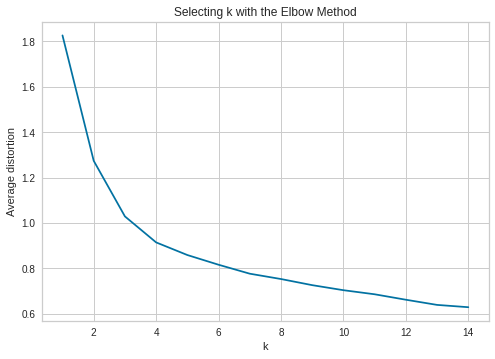

In [91]:
# Plotting the mean distortion to show the elbow plot.

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

4 is appropraite K mean value.

In [75]:
sil_score = []
cluster_list = list(range(2,10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((data_s))
    #centers = clusterer.cluster_centers_
    score = silhouette_score(data_s, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.45388735049136736)
For n_clusters = 3, silhouette score is 0.5429682646592655)
For n_clusters = 4, silhouette score is 0.3868799639660076)
For n_clusters = 5, silhouette score is 0.3108422539885363)
For n_clusters = 6, silhouette score is 0.28200077693858133)
For n_clusters = 7, silhouette score is 0.28040488692546217)
For n_clusters = 8, silhouette score is 0.2692527460007624)
For n_clusters = 9, silhouette score is 0.2571056432646452)


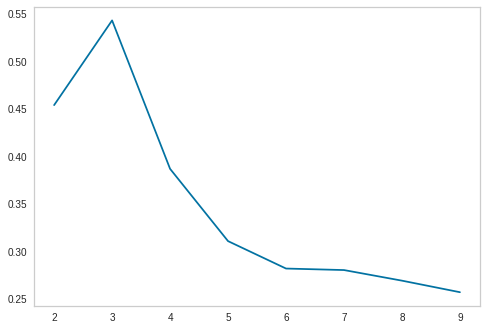

In [76]:
plt.plot(cluster_list,sil_score)
plt.grid()

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f566bf2e0d0>,
                     model=None)

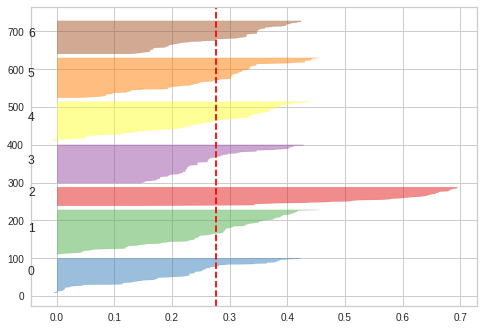

In [93]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(7, random_state = 1))
visualizer.fit(data_s)    

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f566c40a450>,
                     model=None)

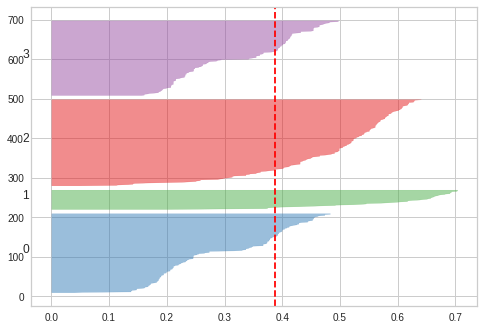

In [96]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state = 1))
visualizer.fit(data_s)    


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f566de0e890>,
                     model=None)

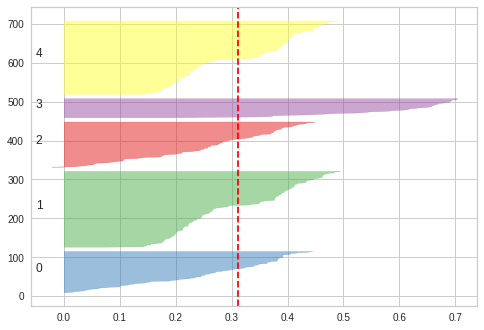

In [97]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state = 1))
visualizer.fit(data_s)

4 is appropraite silhoute  value.

In [30]:
kmeans = KMeans(n_clusters=4, n_init=15, random_state=7)
kmeans.fit(data_s)
kmeans_pred = kmeans.predict(data_s)

In [31]:
kmeans_pred

array([3, 0, 3, 3, 2, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 1, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1,
       3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3,
       1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1,
       1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1,

In [32]:
centroids = kmeans.cluster_centers_
centroids

array([[-1.070864  , -0.90505282,  0.33262581,  1.17110029],
       [ 0.35679514,  1.29571325, -0.54390138, -0.5750638 ],
       [ 1.86222621, -1.10576269,  2.82731942, -0.87432983],
       [ 0.37343847,  0.04107119, -0.55601194, -0.52331725]])

In [33]:
# getting the columns into the centroids

In [34]:
centroid_kmeans = pd.DataFrame(centroids, columns = list(data) )
centroid_kmeans

,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,-1.07,-0.91,0.33,1.17
1,0.36,1.30,-0.54,-0.58
2,1.86,-1.11,2.83,-0.87
3,0.37,0.04,-0.56,-0.52


In [35]:
# Labelling the final column and converting as a categorical attribute

kmeans_label = pd.DataFrame(kmeans_pred, columns= list(['labels']))
kmeans_label['labels'] = kmeans_label['labels'].astype('category')
kmeans_label.head()

,labels
0,3
1,0
2,3
3,3
4,2


In [36]:
# Joining the label dataframe with the data frame.

data_labeled = data.join(kmeans_label)
data_labeled.head()

,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,2,1,1,0,3
1,3,0,10,9,0
2,7,1,3,4,3
3,5,1,1,4,3
4,6,0,12,3,2


In [37]:
# Getting the unique distribution among the labelled data
data_labeled['labels'].value_counts()

0    220
3    200
1    190
2     50
Name: labels, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f566ec8a6d0>,
      dtype=object)

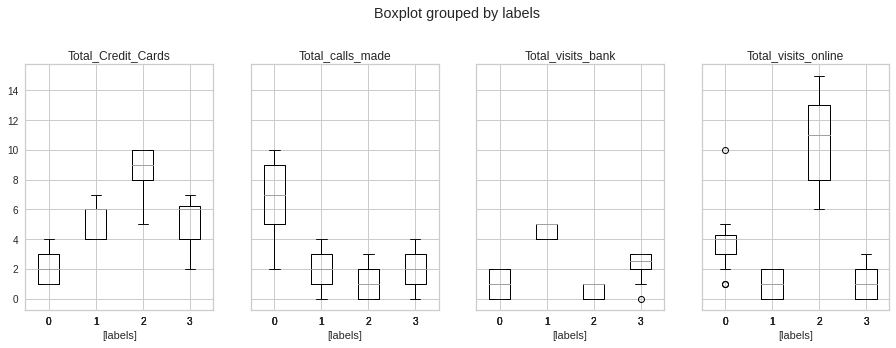

In [38]:
# Displaying the category of the labelled data grouping  using box plots 

data_labeled.boxplot(by = 'labels',  layout=(2,4), figsize=(15, 10))

kmeans Insights

* Customers labeled as 0 seems to have less credit cards and have high total customer care calls and who prefer to visit online more over bank office visit
* Customers labeled as 1 seems to have medium credit cards and have less total customer care calls and who prefer to visit bank office more over online visits
* Customers labeled as 2 seems to have high credit cards and have low total customer care calls and customers who visit online the most
* Customers labeled as 3 seems to have medium credit cards and have less customer care engagement , have low total customer care calls

Hierarchical Clustering

In [39]:
#hierarchical clustering using ward linkage

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

ward_model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
ward_model.fit(data_s)

print("silhouette_score with ward linkage : " , silhouette_score(data_s, ward_model.labels_))

silhouette_score with ward linkage :  0.3729699784919786


In [40]:
# Creating a datafrane joining the original data and labels generated from ward linkage clustering

ward_label = pd.DataFrame(ward_model.labels_, columns=list(['label_ward']))
ward_label['label_ward'] = ward_label['label_ward'].astype('category')
data_labelled_h = data.join(ward_label)

data_labelled_h.head()

,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,label_ward
0,2,1,1,0,0
1,3,0,10,9,0
2,7,1,3,4,1
3,5,1,1,4,0
4,6,0,12,3,2


In [41]:
# Getting the distribution for the ward labbeled data 

data_labelled_h['label_ward'].value_counts()

0    225
1    211
3    174
2     50
Name: label_ward, dtype: int64

{'color_list': ['g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g'],
 'dcoord': [[0.0, 3.018351958945482, 3.018351958945482, 0.0],
  [0.0, 3.2158449613766313, 3.2158449613766313, 0.0],
  [3.018351958945482,
   3.635901290944575,
   3.635901290944575,
   3.2158449613766313],
  [0.0, 2.6953517396814397, 2.6953517396814397, 0.0],
  [0.0, 3.226161896435734, 3.226161896435734, 0.0],
  [2.6953517396814397,
   4.525740805210474,
   4.525740805210474,
   3.226161896435734],
  [3.635901290944575, 5.250088493639615, 5.250088493639615, 4.525740805210474],
  [0.0, 2.158390186625892, 2.158390186625892, 0.0],
  [0.0, 4.182416104388869, 4.182416104388869, 0.0],
  [2.158390186625892, 5.624201426022202, 5.624201426022202, 4.182416104388869],
  [0.0, 3.177561012131068, 3.177561012131068, 0.0],
  [0.0, 4.031368096976216, 4.031368096976216, 0.0]

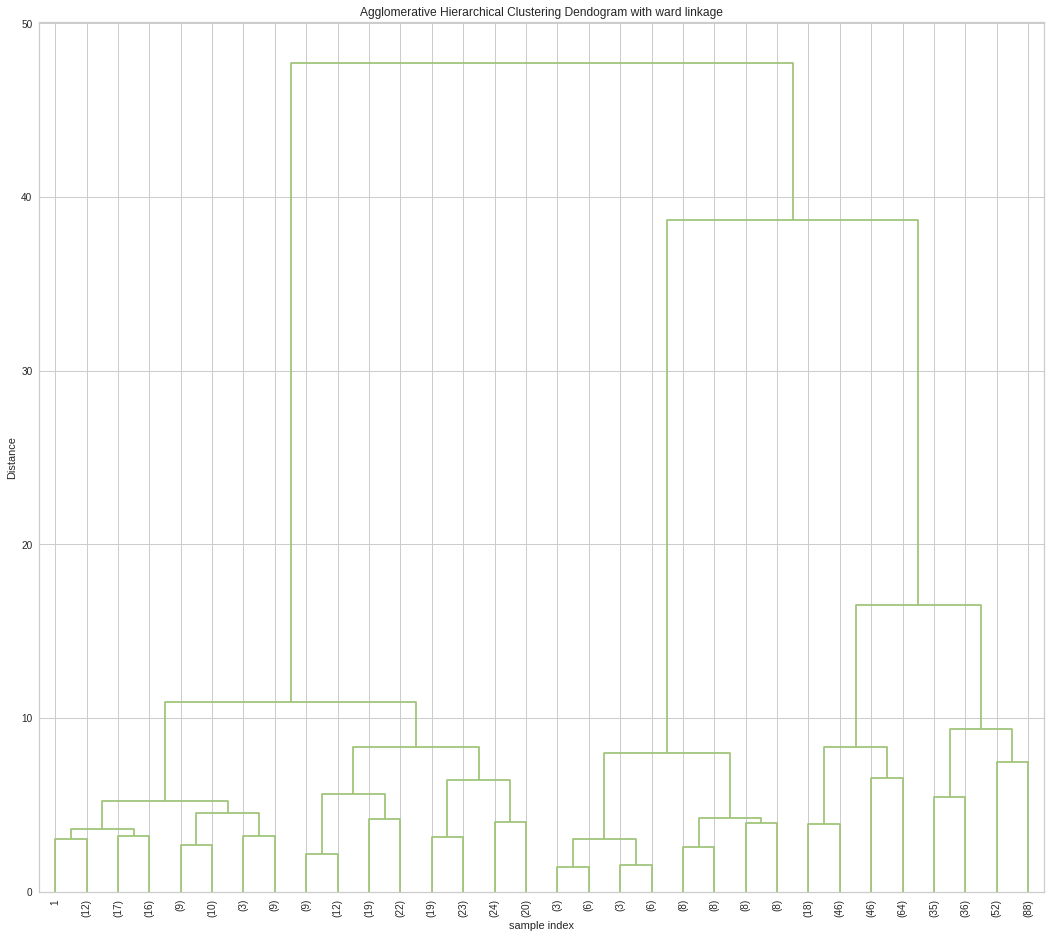

In [42]:
# plotting dendogram with 'ward linkage'

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 16))
plt.title('Agglomerative Hierarchical Clustering Dendogram with ward linkage')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(linkage(data_s, 'ward'), leaf_rotation=90.0, p=4,
           color_threshold=52, leaf_font_size=10, truncate_mode='level')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f566ec78dd0>,
      dtype=object)

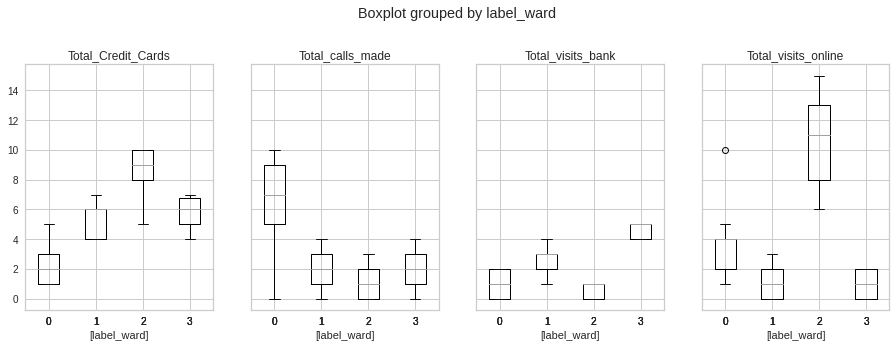

In [43]:
# Plotting the box plots for the various labels 
data_labelled_h.boxplot(by = 'label_ward',  layout=(2,4), figsize=(15, 10))

In [44]:
# hierarchical clustering using single linkage

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

single_model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='single')
single_model.fit(data_s)

print("silhouette_score with single linkage : " , silhouette_score(data_s, single_model.labels_))

silhouette_score with single linkage :  0.10389147178590387


In [45]:
# Creating a datafrane joining the original data and labels generated from single linkage clustering

single_label = pd.DataFrame(single_model.labels_, columns=list(['label_single']))
single_label['label_single'] = single_label['label_single'].astype('category')
data_labelled_single = data.join(single_label)

data_labelled_single.head()

,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,label_single
0,2,1,1,0,3
1,3,0,10,9,1
2,7,1,3,4,0
3,5,1,1,4,0
4,6,0,12,3,2


In [46]:
# Getting the distribution of the clusters using single linkage 

data_labelled_single['label_single'].value_counts()

0    608
2     50
3      1
1      1
Name: label_single, dtype: int64

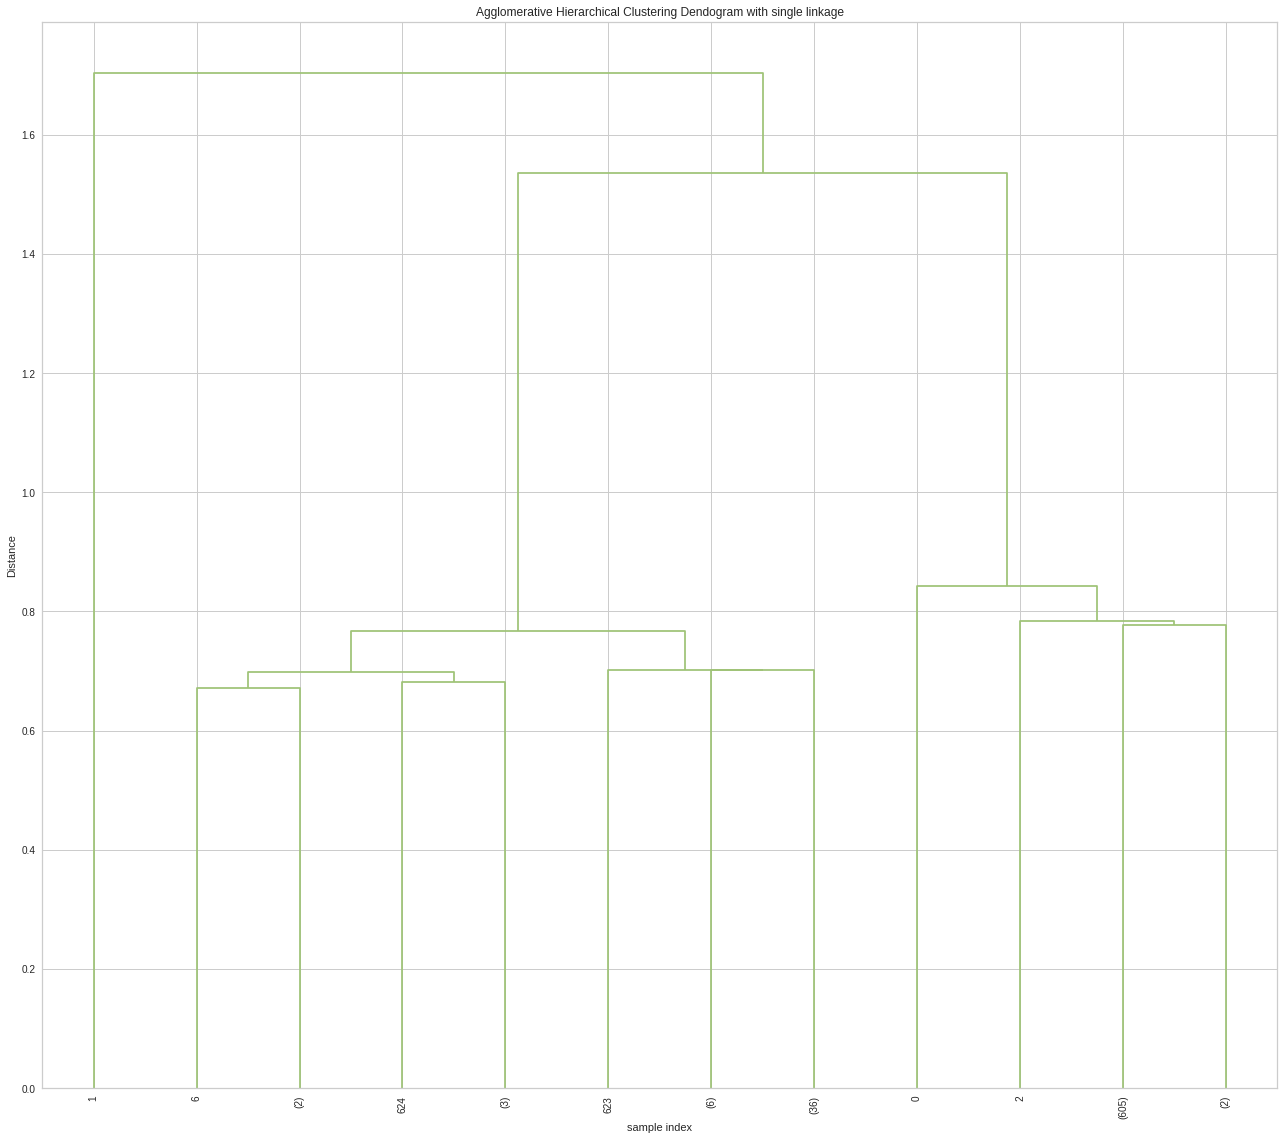

In [47]:
# plotting dendogram with 'single linkage'

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 16))
plt.title('Agglomerative Hierarchical Clustering Dendogram with single linkage')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(linkage(data_s, 'single'), leaf_rotation=90.0, p=4,
           color_threshold=52, leaf_font_size=10, truncate_mode='level')
plt.tight_layout()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f566e344850>,
      dtype=object)

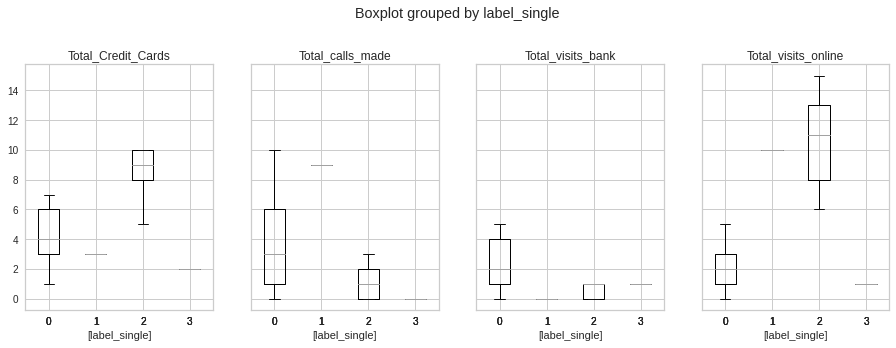

In [48]:
# Plotting the box plots for the various labels

data_labelled_single.boxplot(by = 'label_single',  layout=(2,4), figsize=(15, 10))

In [49]:
#hierarchical clustering using complete linkage

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

complete_model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
complete_model.fit(data_s)

print("silhouette_score with complete linkage : " , silhouette_score(data_s, complete_model.labels_))

silhouette_score with complete linkage :  0.35410330488625136


In [50]:
# Creating a datafrane joining the original data and labels generated from complete linkage clustering

complete_label = pd.DataFrame(complete_model.labels_, columns=list(['label_complete']))
complete_label['label_complete'] = complete_label['label_complete'].astype('category')
data_labelled_complete = data.join(complete_label)

In [51]:
# Getting the distribution of the clusters created by complete linkage

data_labelled_complete['label_complete'].value_counts()

2    385
0    213
1     50
3     12
Name: label_complete, dtype: int64

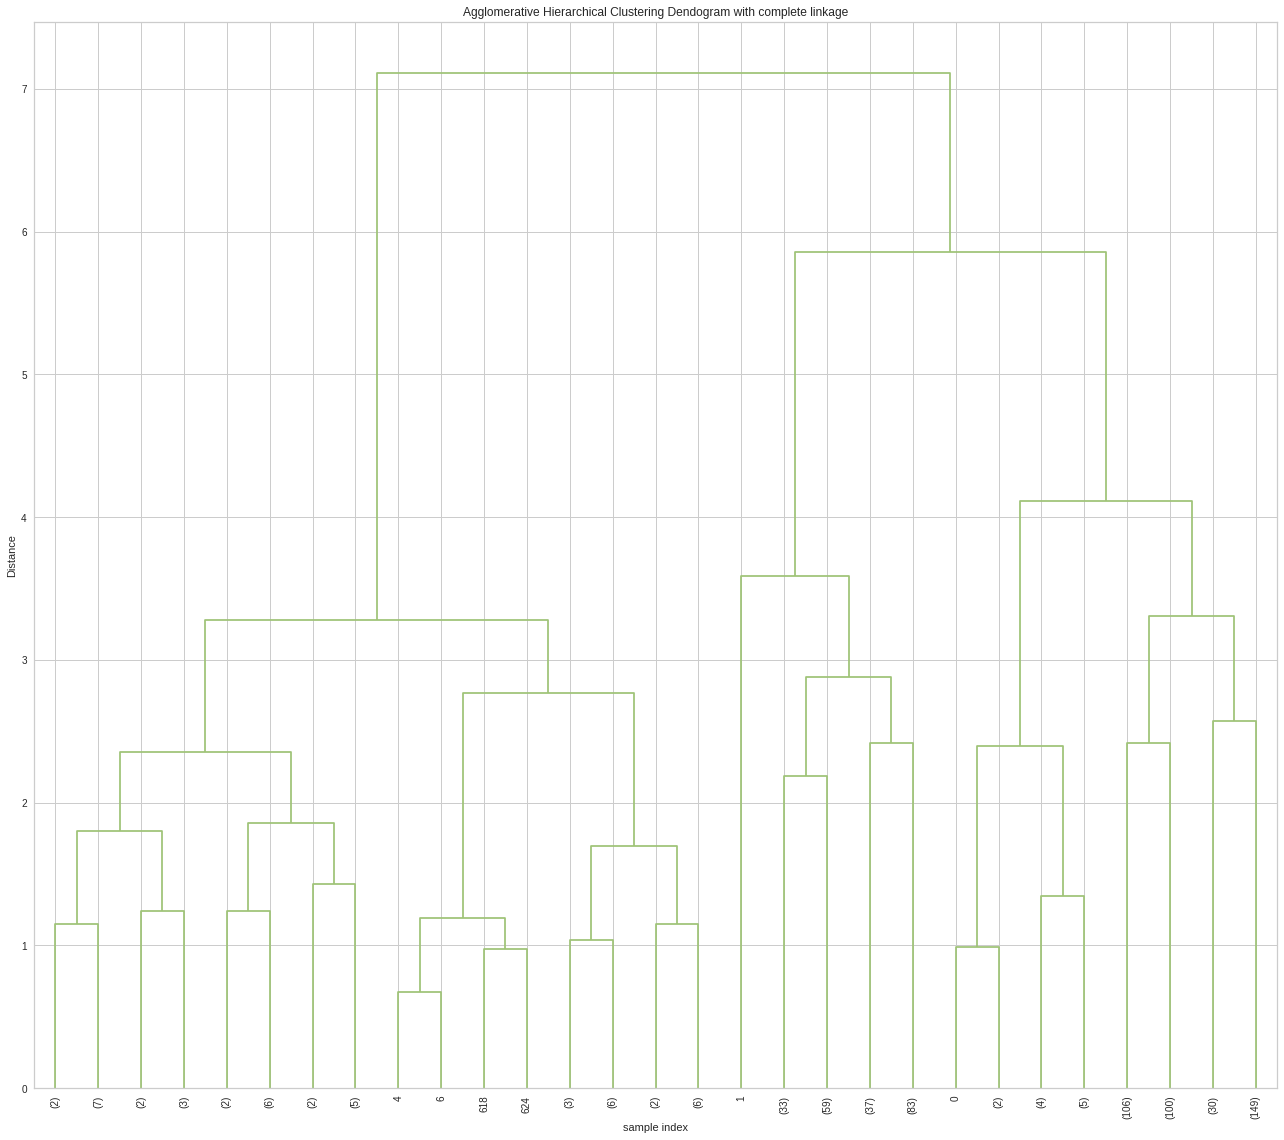

In [52]:
# plotting dendogram with 'complete linkage'

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 16))
plt.title('Agglomerative Hierarchical Clustering Dendogram with complete linkage')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(linkage(data_s, 'complete'), leaf_rotation=90.0, p=4,
           color_threshold=52, leaf_font_size=10, truncate_mode='level')
plt.tight_layout()

In [53]:
#hierarchical clustering using average linkage

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

average_model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='average')
average_model.fit(data_s)

print("silhouette_score with complete linkage : " , silhouette_score(data_s, average_model.labels_))

silhouette_score with complete linkage :  0.496541564538832


In [54]:
# Creating a datafrane joining the original data and labels generated from complete linkage clustering


average_label = pd.DataFrame(average_model.labels_, columns=list(['label_average']))
average_label['label_average'] = average_label['label_average'].astype('category')
data_labelled_average = data.join(average_label)

data_labelled_average.head()

,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,label_average
0,2,1,1,0,0
1,3,0,10,9,3
2,7,1,3,4,2
3,5,1,1,4,0
4,6,0,12,3,1


In [55]:
# Getting the distribution of the clusters using the average linkage

data_labelled_average['label_average'].value_counts()

2    385
0    224
1     50
3      1
Name: label_average, dtype: int64

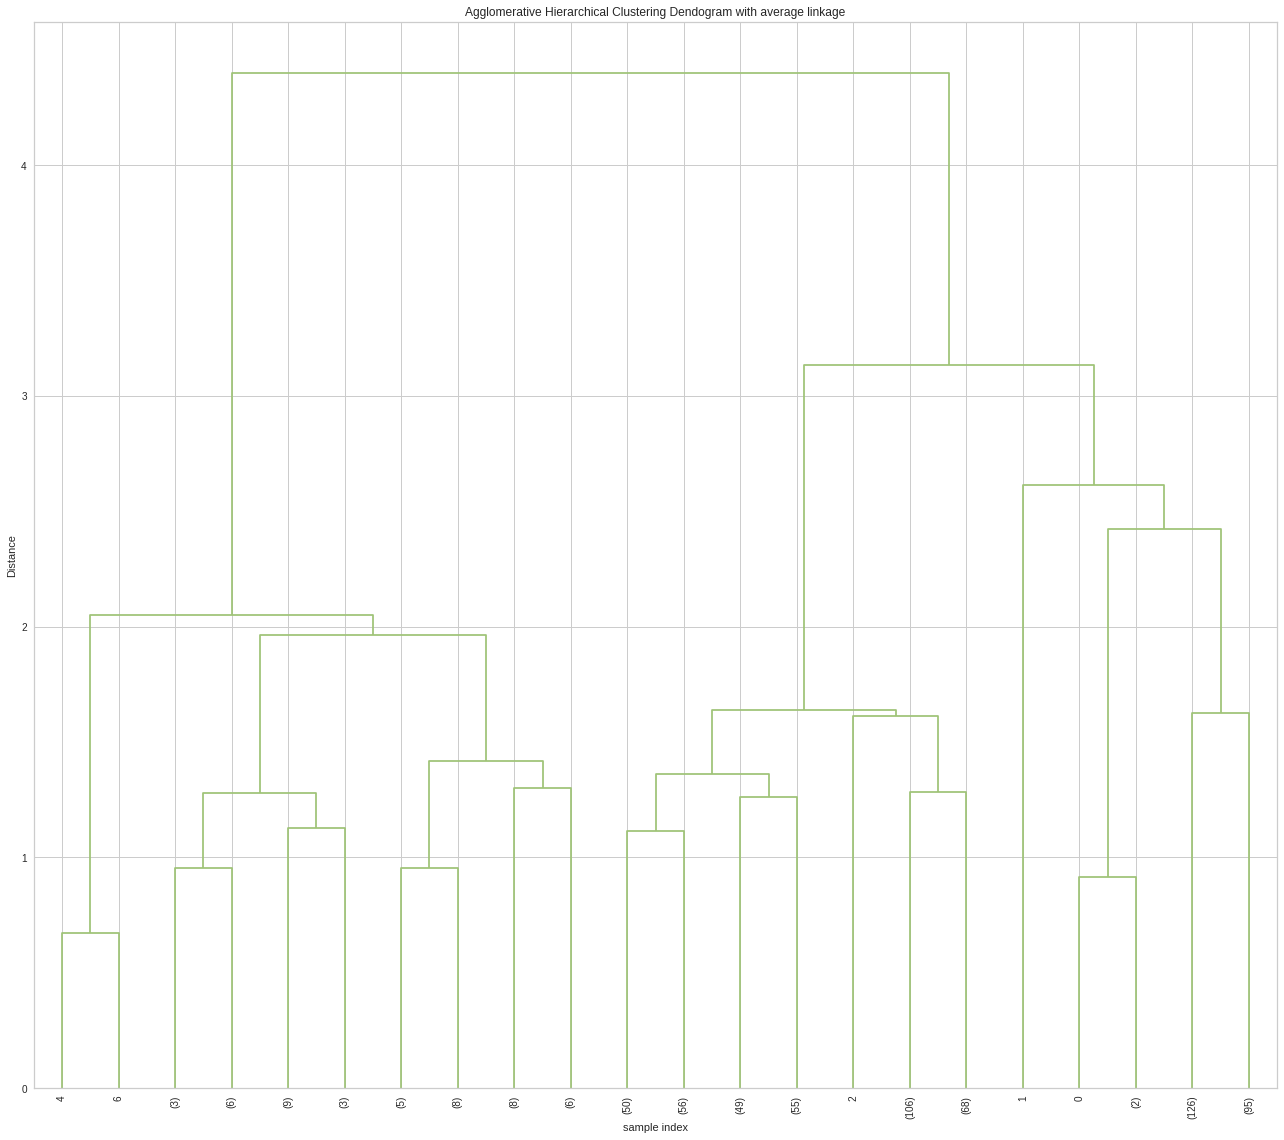

In [56]:
# plotting dendogram with 'average linkage'

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 16))
plt.title('Agglomerative Hierarchical Clustering Dendogram with average linkage')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(linkage(data_s, 'average'), leaf_rotation=90.0, p=4,
           color_threshold=52, leaf_font_size=10, truncate_mode='level')
plt.tight_layout()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f566dde8690>,
      dtype=object)

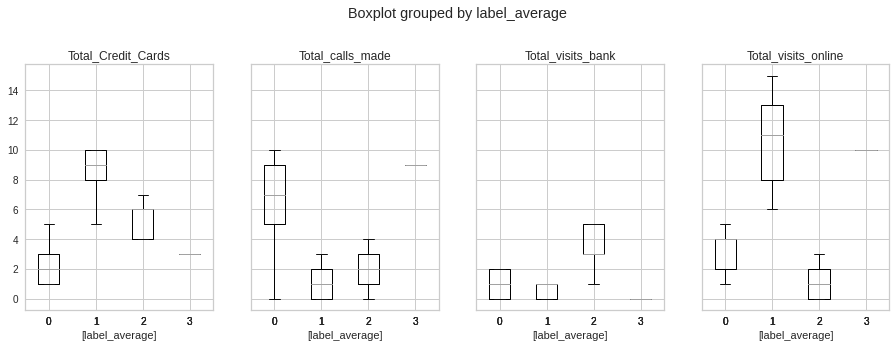

In [57]:
# Plotting the box plots for the various labels

data_labelled_average.boxplot(by = 'label_average',  layout=(2,4), figsize=(15, 10))

In [58]:
print("silhouette score for k-means with 4 clusters : ", silhouette_score(data_s, kmeans.labels_))
print("Avg. silhouette score for hierarchical clustering with 4 clusters : ", 
      (silhouette_score(data_s, ward_model.labels_) + silhouette_score(data_s, single_model.labels_) 
       +  silhouette_score(data_s, complete_model.labels_) + silhouette_score(data_s, average_model.labels_)) / 4)

silhouette score for k-means with 4 clusters :  0.3868799639660076
Avg. silhouette score for hierarchical clustering with 4 clusters :  0.3318765799257415


Compare K-means clusters with Hierarchical clusters

Text(0.5, 0.92, '3D plot of KMeans Clustering')

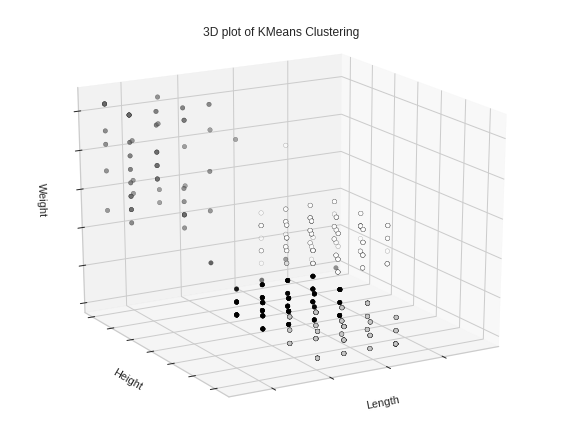

In [59]:
# Demonstrate the 3d plot using mplot3d)
from mpl_toolkits.mplot3d import Axes3D

## 3D plots of k-means clusters

fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=60)
ax.scatter(data_s.iloc[:, 0], data_s.iloc[:, 1], data_s.iloc[:, 2],c=kmeans.labels_.astype(np.float), edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Length')
ax.set_ylabel('Height')
ax.set_zlabel('Weight')
ax.set_title('3D plot of KMeans Clustering')

Text(0.5, 0.92, '3D plots of Hierarchical clusters using ward linkage')

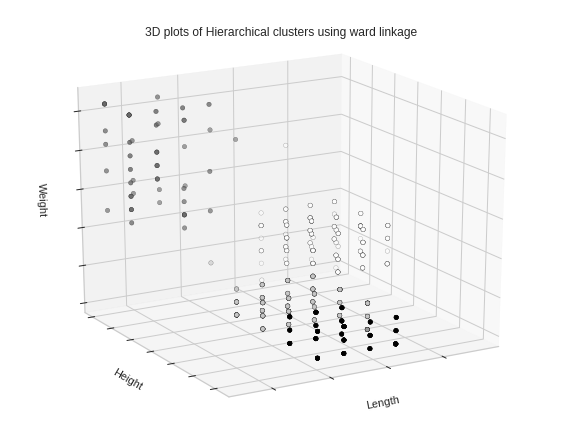

In [60]:
## 3D plots of Hierarchical clusters using ward linkage

fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=60)
ax.scatter(data_s.iloc[:, 0], data_s.iloc[:, 1], data_s.iloc[:, 2],c=ward_model.labels_.astype(np.float), edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Length')
ax.set_ylabel('Height')
ax.set_zlabel('Weight')
ax.set_title('3D plots of Hierarchical clusters using ward linkage')

Text(0.5, 0.92, '3D plots of Hierarchical clusters using single linkage')

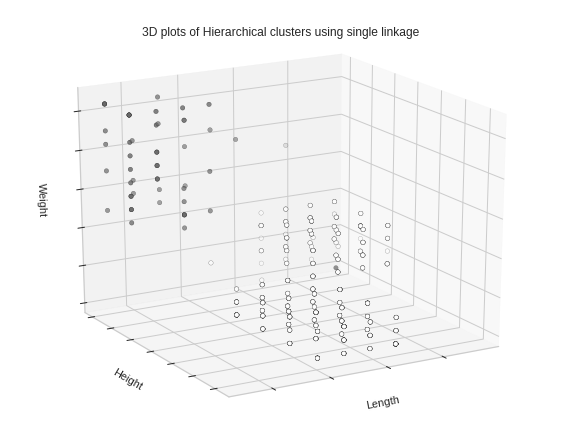

In [61]:
## 3D plots of Hierarchical clusters using single linkage

fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=60)
ax.scatter(data_s.iloc[:, 0], data_s.iloc[:, 1], data_s.iloc[:, 2],c=single_model.labels_.astype(np.float), edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Length')
ax.set_ylabel('Height')
ax.set_zlabel('Weight')
ax.set_title('3D plots of Hierarchical clusters using single linkage')

Text(0.5, 0.92, '3D plots of Hierarchical clusters using complete linkage')

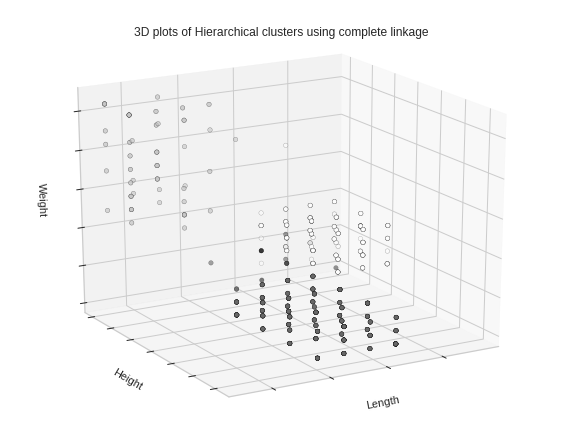

In [62]:
## 3D plots of Hierarchical clusters using complete linkage

fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=60)
ax.scatter(data_s.iloc[:, 0], data_s.iloc[:, 1], data_s.iloc[:, 2],c=complete_model.labels_.astype(np.float), edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Length')
ax.set_ylabel('Height')
ax.set_zlabel('Weight')
ax.set_title('3D plots of Hierarchical clusters using complete linkage')

Text(0.5, 0.92, '3D plots of Hierarchical clusters using average linkage')

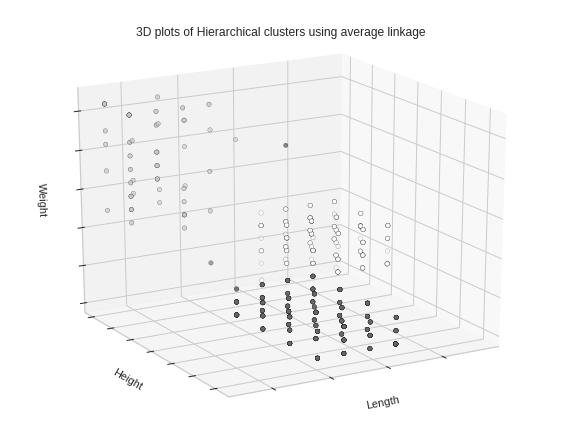

In [63]:
## 3D plots of Hierarchical clusters using average linkage

fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=60)
ax.scatter(data_s.iloc[:, 0], data_s.iloc[:, 1], data_s.iloc[:, 2],c=average_model.labels_.astype(np.float), edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Length')
ax.set_ylabel('Height')
ax.set_zlabel('Weight')
ax.set_title('3D plots of Hierarchical clusters using average linkage')

In [64]:
data_labeled['labels'].value_counts()

0    220
3    200
1    190
2     50
Name: labels, dtype: int64

Insights

k-means : k-means clustering has seems somewhat uniformly data distribution among the 0,1,3 labels
Label 2 has the minimum cluster size

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f566dde1d50>,
      dtype=object)

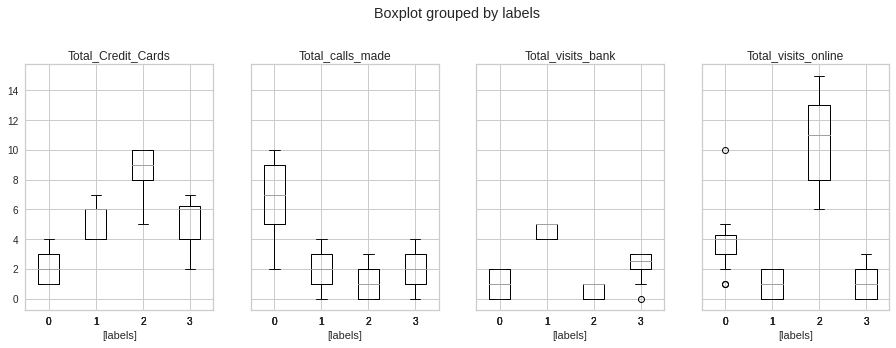

In [66]:
# Plotting the box plots for the various labels using kmeans

data_labeled.boxplot(by = 'labels',  layout=(2,4), figsize=(15, 10))

In [67]:
# Getting the distribution of the Hierarchical clusters 

print('clusters distribution using ward linkage')
print(data_labelled_h['label_ward'].value_counts())

print('clusters distribution using single linkage')
print(data_labelled_single['label_single'].value_counts())

print('clusters distribution using complete linkage')
print(data_labelled_complete['label_complete'].value_counts())

print('clusters distribution using average linkage')
print(data_labelled_average['label_average'].value_counts())

clusters distribution using ward linkage
0    225
1    211
3    174
2     50
Name: label_ward, dtype: int64
clusters distribution using single linkage
0    608
2     50
3      1
1      1
Name: label_single, dtype: int64
clusters distribution using complete linkage
2    385
0    213
1     50
3     12
Name: label_complete, dtype: int64
clusters distribution using average linkage
2    385
0    224
1     50
3      1
Name: label_average, dtype: int64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f566c977110>,
      dtype=object)

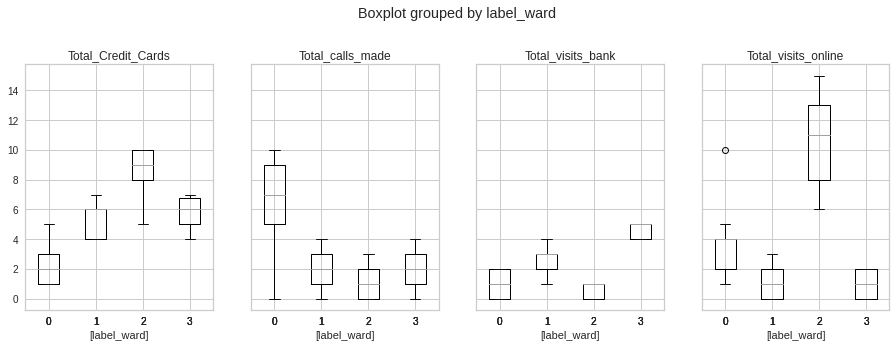

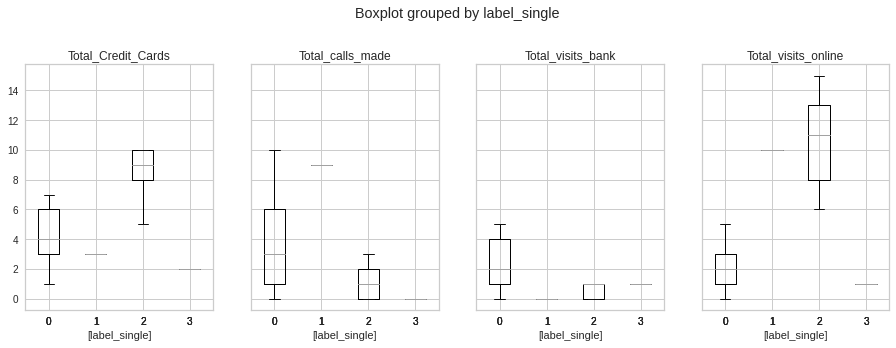

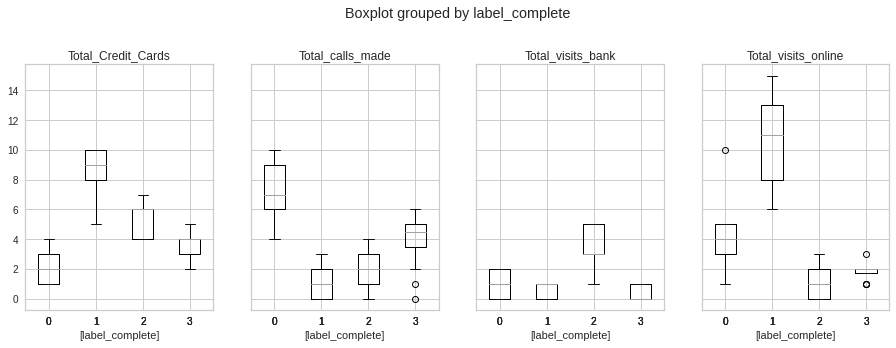

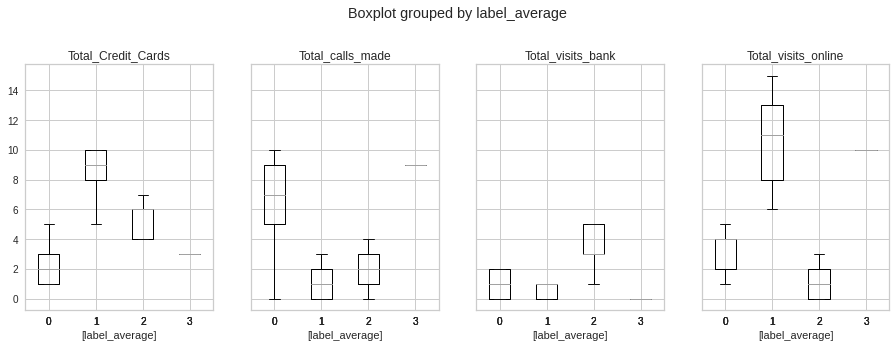

In [68]:
# Plotting the box plots for the various labels using the Hierarchical clusters

data_labelled_h.boxplot(by = 'label_ward',  layout=(2,4), figsize=(15, 10))
data_labelled_single.boxplot(by = 'label_single',  layout=(2,4), figsize=(15, 10))
data_labelled_complete.boxplot(by = 'label_complete',  layout=(2,4), figsize=(15, 10))
data_labelled_average.boxplot(by = 'label_average',  layout=(2,4), figsize=(15, 10))

Hierarchical clusters Insights

As we see in above comparisions , hierarchical clustering using ward linkage is the one that good clustering distribution

Answer for key business  qustions:

 * It seems there are around 4-5 segments around which the cutomers can be categorized.

* Customers labeled as 0 seems to have less credit cards and have high total customer care calls and who prefer to visit online more over bank office visit
* Customers labeled as 1 seems to have medium credit cards and have less total customer care calls and who prefer to visit bank office more over online visits
* Customers labeled as 2 seems to have high credit cards and have low total customer care calls and customers who visit online the most
* Customers labeled as 3 seems to have medium credit cards and have less customer care engagement , have low total customer care calls`

Recommendations : 

* Customers labelled as 0 need to given more attention by the customer care , as they are the ones that have most number of calls made to customer care.
* Helping category label 0 customers would increase customer atisfaction to a significant level.

* Cutomers labbeled as 2 are the premium customer that have the higher number of credit cards and visit online website more often . These customers would be targetted for better online exprience and should be provided incentives to increase who can bring more revenue to the bank.

* Customers labelled as 1 and 3 , are more general customers who visit online and bank on a regular basis with specific needs. These customer needs to be take care the most.